In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100
import seaborn as sns

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
import statsmodels.stats.outliers_influence as sso

In [2]:
def check_coef(df, threshold=0):
    import seaborn as sns
    df_coef = df.corr()
    sns.heatmap(df.corr(), annot=True)
    plt.show()

In [3]:
def draw_simple_reg_line(df, x_labels, y_label):
    #Do not plot confidence internval, for now. 
    for xi in x_labels:
        _ = sns.regplot(x=xi, y= y_label, data = df, color = 'r', ci = None)
        plt.show()

In [4]:
def scatter_plot(df,x_label, y_label):
    y = df[y_label].values
    for xi in x_label:
        x = df[xi].values
        _ = plt.plot(x, y, 'o', color = 'b')
        plt.xlabel(xi)
        plt.ylabel(y_label)
        plt.title(xi+" to "+y_label)
        plt.show()

In [5]:
# x_labels must be a list
def linear_regression(df, x_labels, y_label):
    x_param = ''
    for x in x_labels:
        x_param+="Q(\"{}\")+".format(x)
    x_param = x_param[:-1]
    y_label  = "Q(\""+y_label+"\")"
    df1_result = smf.ols(y_label+"~"+x_param, data = df).fit()
    print(df1_result.summary())
    return df1_result

In [6]:
def check_outlier(df, x_label, y_label, df1_result):
    import statsmodels.stats.outliers_influence as sso

    x = df[x_label].values
    st, data, ss2 = sso.summary_table(df1_result, alpha=0.05)
    y = data[:, 10]

    plt.plot(x, y, 'o', color = 'gray')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.show()
    return st, data, ss2

In [7]:
def check_influential_observ(df1, x_label, y_label, df1_result):
    st, data, ss2 = sso.summary_table(df1_result, alpha=0.05)
    x = df1[x_label].values
    cook_dist = data[:, 11]
    print(cook_dist)
    plt.plot(x, cook_dist, 'o', color = 'gray')
    plt.axhline(y=1, color="red")
    plt.show()

In [8]:
def check_norm(resid, bins='auto'):
    # Run Shapiro test
    stat, p = stats.shapiro(resid)
    print(f'Shapiro test: statistics = {stat:.4f}, p = {p:.4f}\n')
    
    # Draw historgram
    print('Histogram')
    plt.hist(resid, bins=bins)
    plt.show()
    
    # Draw QQ plot
    print('QQ plot')
    fig = sm.qqplot(resid, stats.norm, fit=True, line='45')
    plt.show()

In [9]:
def getEquation(df_result):
    print("y = ",end="")
    text = ''
    for name, coef in zip(df_result.params.index, df_result.params):
        text+="{:.3f} * {} + ".format(coef, name)
    text = text[:-2]
    print(text)

In [10]:
def reg_analysis(df, x_labels, y_label):
    df.fillna(value=0, inplace=True)
    display(df.describe())
    check_coef(df[x_labels])
    print("1 if larger than 0.5...")
    scatter_plot(df,x_labels, y_label)
    df_result = linear_regression(df, x_labels, y_label)
    getEquation(df_result)
    print("Residual Test...")
    print("Normality")
    check_norm(df_result.resid_pearson)
    print("Influential Observations")
    check_influential_observ(df, 'student_id', y_label, df_result)
    print("Outliers")
    st, data, ss2 = check_outlier(df, 'student_id', y_label, df_result)
    return st, data, ss2

In [11]:
def _std_helper(df_col):
    return (df_col - df_col.mean())/df_col.std()

In [12]:
def _norm_helper(df_col):
    return (df_col - df_col.min())/(df_col.max()-df_col.min())

In [13]:
def standardize(df, x_labels):
    for x_label in x_labels:
        df[x_label] = _std_helper(df[x_label])
    return df

In [14]:
def normalize(df, x_labels):
    for x_label in x_labels:
        df[x_label] = _norm_helper(df[x_label])
    return df

In [15]:
#forward_selection(input_df = df18_6, depv = 'Score', indepv = ['Drive', 'Fair', 'Green', 'Putt', 'Sand'])
def forward_selection(input_df, x_labels, y_label, VERBOSE=True):
    selected = []
    candidates = x_labels.copy()

    best_adjr2 = -1
    best_subset = []
    while len(candidates) > 0:
        if(VERBOSE):
            print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []

        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            
            modelstr =  "Q(\"{}\")".format(y_label)+ " ~ " + "+".join(["Q(\"{}\")".format(x_label) for x_label in tmplist])
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            #print(df18_result6tmp.summary())
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        
        #find the best element
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]

        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")
        if(VERBOSE):
            print("===============")
            print("Current best model: ", selected)
            print("Current best AdjR2: ", this_adjr2)


        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected


        candidates = set(candidates) - set(selected)
        candidates = list(candidates)

    #print out the best result
    if(VERBOSE):
        print("best_adjr2 = ", best_adjr2)
        print("best_subset = ", best_subset)

    #run the best model again
    modelstr = "Q(\"{}\")".format(y_label) + " ~ " + "+".join(["Q(\"{}\")".format(x_label) for x_label in best_subset])
    result6b = smf.ols(modelstr, data=input_df).fit()
    
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    variables = result6b.model.exog
    vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
    
    if(VERBOSE):
        print(result6b.summary())
    return best_adjr2, best_subset, vif

## DSAP107

In [16]:
DSAP107 = pd.read_excel('../../data/Semester weekly regression 2.0/DSAP107.xlsx')

In [17]:
len(DSAP107)

105

In [19]:
DSAP107.columns

Index(['Unnamed: 0', 'student_id', 'Section', 'Homework 0 (1554)',
       'Homework 1 (1475)', 'Homework 2 (1750)', 'Homework 3 (1808)',
       'Homework 4 (1859)', 'Homework 5 (1954)', 'Homework 6 (2053)',
       'Homework 7 (2129)', 'Homework8 (2232)', 'Quiz (1582)',
       'Midterm (2042)', 'Final (2346)', 'total_watch_time', 'watch_freq',
       'backward_sec', 'backward_times', 'forward_sec', 'forward_times',
       'pause_freq', 'period 0', 'period 1', 'period 2', 'period 3',
       'period 4', 'period 5', 'avg_playback_rate'],
      dtype='object')

## Prepare Ys

In [20]:
HW = ['Homework 0 (1554)',
       'Homework 1 (1475)', 'Homework 2 (1750)', 'Homework 3 (1808)',
       'Homework 4 (1859)', 'Homework 5 (1954)', 'Homework 6 (2053)',
       'Homework 7 (2129)', 'Homework8 (2232)']

DSAP107['HW_sum'] = 0
for hw in HW:
    DSAP107['HW_sum'] +=DSAP107[hw]
DSAP107['HW_mean'] = DSAP107['HW_sum']/len(HW)
DSAP107['midterm'] = DSAP107['Midterm (2042)']
DSAP107['final'] = DSAP107['Final (2346)']

## Subtract useful columns

In [21]:
sub_cols = ['student_id','midterm', 'final', 'HW_mean', 'total_watch_time', 'watch_freq',
       'backward_sec', 'backward_times', 'forward_sec', 'forward_times',
       'pause_freq', 'period 0', 'period 1', 'period 2', 'period 3',
       'period 4', 'period 5', 'avg_playback_rate']
DSAP107_sub = DSAP107[sub_cols]

# Preprocess

### remove total_watch_time==0 

In [22]:
DSAP107_sub[DSAP107_sub['total_watch_time']<=0]

,student_id,midterm,final,HW_mean,total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate
37,101,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,112,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,120,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,131,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,135,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,152,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
DSAP107_sub = DSAP107_sub[DSAP107_sub['total_watch_time']>0]

In [24]:
len(DSAP107_sub)

99

## Defined Ys and Xs labels

In [25]:
y_label_final = 'final'
y_label_mid = 'midterm'
y_label_hw = 'HW_mean'
y_labels = [y_label_final, y_label_mid, y_label_hw]

### basis Xs

In [26]:
x_labels_basis = ['total_watch_time','avg_playback_rate']

### collinear Xs

In [27]:
x_label_actions = ['backward_times', 'forward_times','pause_freq', 'sum_action_times', 'backward_sec', 'forward_sec', 'sum_action_sec']

### period Xs

In [30]:
x_labels_period_sec = ['period {}'.format(i) for i in range(6)]
x_labels_period_percent = ['period {}_p'.format(i) for i in range(6)]
x_labels_period_type = ['period {}_type'.format(i) for i in range(6)]
x_labels_period = [x_labels_period_sec, x_labels_period_percent, x_labels_period_type]

In [31]:
x_labels_permutations = []
for action_time in x_label_actions:
    for period in x_labels_period:
        x_labels_permutations.append(x_labels_basis+[action_time]+period)

In [32]:
len(x_labels_permutations)

21

## Prepare Xs

### calculate period percentage (x_labels_period_percent)

In [33]:
for i in range(6):
    DSAP107_sub.loc[:,'period '+str(i)+"_p"] = DSAP107_sub['period '+str(i)]/DSAP107_sub['total_watch_time']

### calculate period type (x_labels_period_type)

In [34]:
for i in range(6):
    DSAP107_sub['period '+str(i)+'_type'] = [0 for i in range((DSAP107_sub.shape[0]))]
    DSAP107_sub.loc[ (DSAP107_sub['period '+str(i)+"_p"]) > (DSAP107_sub.describe()['period '+str(i)+"_p"]['50%']), 'period '+str(i)+'_type'] = 1

### add up all actions (x_label_actions_sec_sum and x_label_actions_times_sum)

In [35]:
# DSAP107_sub.loc[:,'thinking_times'] = DSAP107_sub['backward_times']+DSAP107_sub['pause_freq']
# DSAP107_sub.loc[:,'boring_times'] = DSAP107_sub['forward_times']+DSAP107_sub['pause_freq']
DSAP107_sub.loc[:,'sum_action_times'] = DSAP107_sub['forward_times']+DSAP107_sub['backward_times']+DSAP107_sub['pause_freq']
DSAP107_sub.loc[:,'sum_action_sec'] = DSAP107_sub['forward_sec']+DSAP107_sub['backward_sec']

## Test Regression

In [36]:
print("There are {} regression tests".format(len(y_labels)*len(x_labels_permutations)))

There are 63 regression tests


In [38]:
best_adj_lis=[]
best_subset_lis = []
best_vif_lis = []
for y_label in y_labels:
    current_best_adj = 0
    current_best_subset = []
    current_bes_vif = []
    print("Current Y: {}".format(y_label))
    for x_labels in x_labels_permutations:
        best_adjr2, best_subset, vif = forward_selection(DSAP107_sub, x_labels, y_label, False)
        if(current_best_adj < best_adjr2):
            current_best_adj = best_adjr2
            current_best_subset = best_subset
            current_bes_vif = vif
    
    best_adj_lis.append(current_best_adj)
    best_subset_lis.append(current_best_subset)
    best_vif_lis.append(best_vif_lis)
    print("best_adjr2 = ", current_best_adj)
    print("best_subset = ", current_best_subset)
    print("best_vif = ", current_bes_vif)
    print("------------------------------------------------------------------------------------------------------------------------------------------------------")    

Current Y: final
best_adjr2 =  0.43480748969625704
best_subset =  ['total_watch_time', 'avg_playback_rate', 'period 4_p', 'backward_sec']
best_vif =  [32.381811932127476, 1.8035779566280623, 1.064792185578849, 1.027930454383058, 1.8356940281872114]
------------------------------------------------------------------------------------------------------------------------------------------------------
Current Y: midterm
best_adjr2 =  0.2943174869739147
best_subset =  ['total_watch_time', 'avg_playback_rate', 'period 2_type']
best_vif =  [30.108319307188808, 1.0859412639618806, 1.018557163003682, 1.1039627339289033]
------------------------------------------------------------------------------------------------------------------------------------------------------
Current Y: HW_mean
best_adjr2 =  0.44518676993795014
best_subset =  ['total_watch_time', 'avg_playback_rate', 'period 5_type', 'backward_sec']
best_vif =  [33.44685933921371, 1.8060949594942728, 1.0440738544306427, 1.04216976337490

Y: final
Xs: ['total_watch_time', 'avg_playback_rate', 'period 4_p', 'backward_sec']
R_adj: 0.43480748969625704


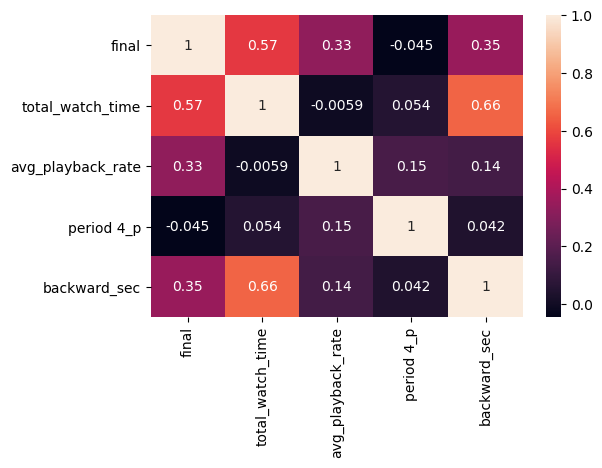

Y: midterm
Xs: ['total_watch_time', 'avg_playback_rate', 'period 2_type']
R_adj: 0.2943174869739147


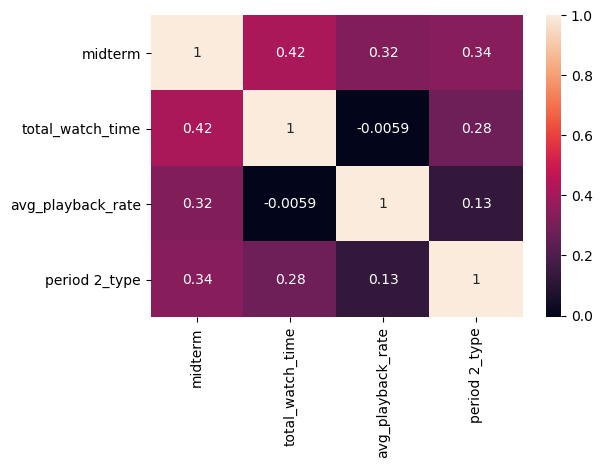

Y: HW_mean
Xs: ['total_watch_time', 'avg_playback_rate', 'period 5_type', 'backward_sec']
R_adj: 0.44518676993795014


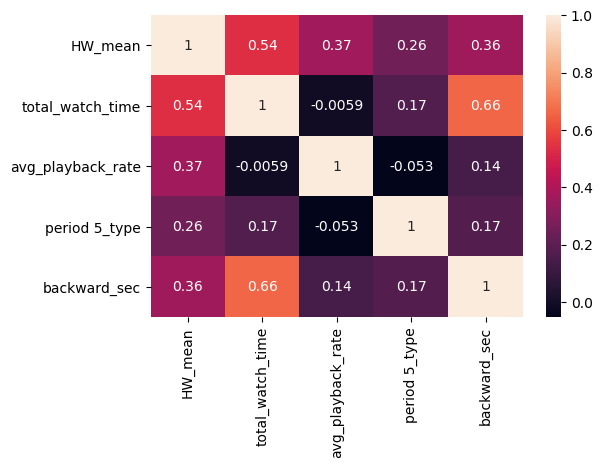

In [41]:
for i in range(len(y_labels)):
    print("Y: {}".format(y_labels[i]))
    print("Xs: {}".format(best_subset_lis[i]))
    print("R_adj: {}".format(best_adj_lis[i]))
    check_coef(DSAP107_sub[[y_labels[i]]+best_subset_lis[i]])

# 以下是舊進度

******

,student_id,midterm,final,total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate,thinking_times,all_actions
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,115.444444,50.737374,50.792929,19782.400120,0.842786,6496.010101,168.949495,6018.939394,241.808081,270.838384,0.158256,0.020499,0.097366,0.318966,0.206674,0.198238,1.523980,439.787879,681.595960
std,31.018501,40.677825,33.149246,11896.444354,0.483959,8362.678571,192.383512,7888.688435,403.309211,302.472488,0.183040,0.106119,0.127823,0.228651,0.152590,0.184034,0.299293,446.817597,813.828179
min,64.000000,0.000000,0.000000,1.000000,0.000049,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,88.500000,0.000000,0.000000,13327.808333,0.626238,975.000000,32.000000,1134.500000,20.000000,82.500000,0.021742,0.000000,0.000000,0.172791,0.095914,0.066494,1.280673,134.000000,170.500000
50%,115.000000,74.000000,61.500000,19484.266667,0.875151,3965.000000,83.000000,2828.000000,80.000000,167.000000,0.098693,0.000000,0.049382,0.288328,0.204301,0.163837,1.493685,306.000000,436.000000
75%,142.500000,86.000000,77.000000,26655.741667,1.094102,9043.000000,250.500000,7180.500000,305.000000,352.500000,0.227235,0.000000,0.166718,0.410788,0.304145,0.284685,1.772643,637.500000,839.000000
max,168.000000,98.000000,91.500000,69769.233333,2.687745,47268.000000,869.000000,46298.000000,2353.000000,2282.000000,0.998600,1.000000,0.760000,1.000000,0.674660,0.991624,2.380491,2539.000000,4678.000000


1 if larger than 0.5...


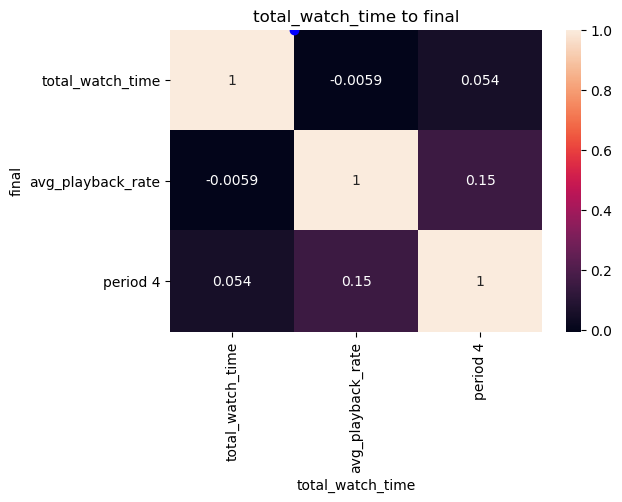

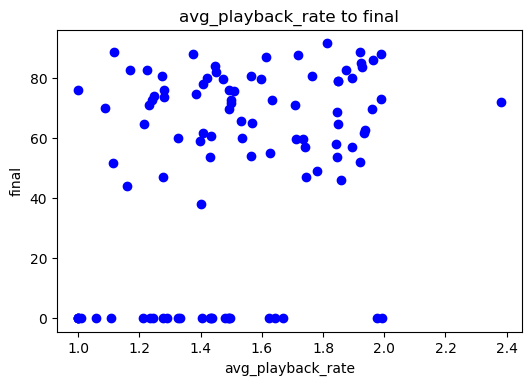

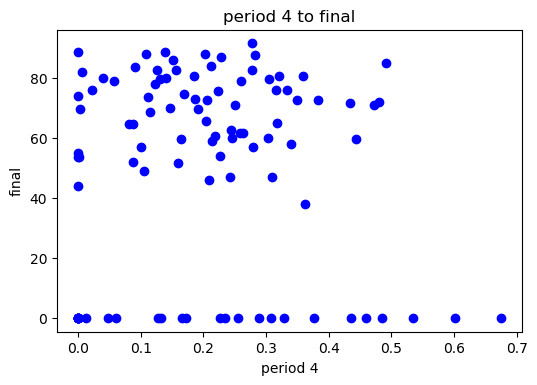

                            OLS Regression Results                            
Dep. Variable:             Q("final")   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     25.81
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           2.69e-12
Time:                        10:22:20   Log-Likelihood:                -457.07
No. Observations:                  99   AIC:                             922.1
Df Residuals:                      95   BIC:                             932.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -34

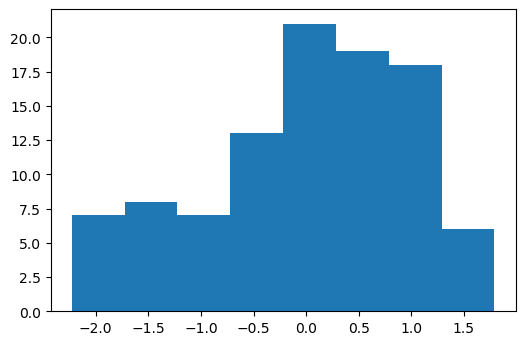

QQ plot


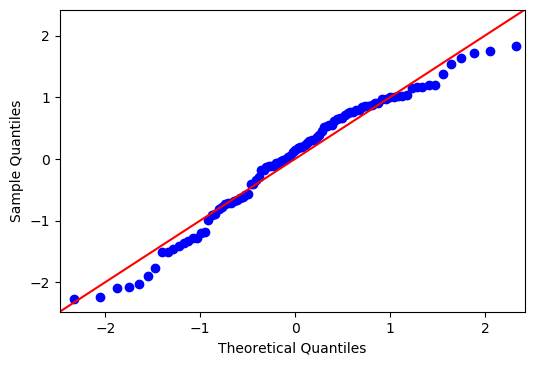

Influential Observations
[9.44224125e-03 3.36387615e-03 6.23271568e-03 2.52952941e-03
 7.21600702e-04 2.80038414e-02 2.20685570e-03 1.91204521e-02
 9.25116743e-04 6.59737237e-03 5.95449348e-07 4.47508396e-03
 7.88096058e-03 3.37886365e-03 1.53126753e-02 6.92375767e-03
 1.10315882e-05 6.26841065e-03 7.18181193e-04 1.35095028e-02
 2.56749173e-04 6.18747963e-04 1.05903054e-04 7.29595681e-04
 4.07798773e-03 1.81379256e-02 1.58859617e-02 1.09068956e-02
 6.97678659e-03 3.77600556e-03 9.27465509e-03 4.14511937e-04
 1.17427482e-03 4.39856868e-03 3.99912207e-03 1.64390512e-03
 4.15901123e-02 1.07691353e-02 3.55536503e-03 5.54920932e-02
 9.01024979e-03 1.09147172e-02 9.28009972e-04 1.02119671e-02
 7.04120061e-06 8.49134461e-03 3.14483967e-06 7.01542802e-04
 3.32440910e-02 2.07908355e-02 3.14105277e-01 1.09559168e-04
 1.43125154e-04 3.23461123e-04 1.53925235e-02 3.20585817e-02
 1.76362727e-03 1.10770248e-02 1.66477910e-02 4.42097121e-02
 5.80520630e-03 8.13013711e-04 3.19378650e-03 1.95741358e-02

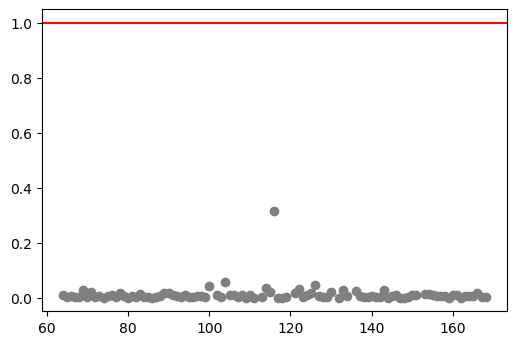

Outliers


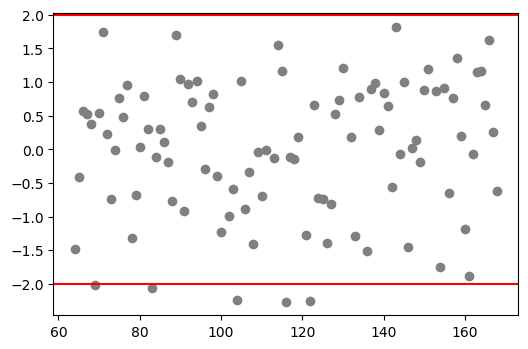

In [96]:
x_labels_best = ['total_watch_time', 'avg_playback_rate', 'period 5_type', 'backward_sec', 'forward_sec', 'pause_freq', 'backward_times', 'forward_times', 'period 3_type']
st, data, ss2 = reg_analysis(DSAP107_sub, x_labels_best, y_label)

## Standarized numbers

In [35]:
DSAP107_sub = standardize(DSAP107_sub, x_labels)

## Normalize numbers

In [54]:
DSAP107_sub = normalize(DSAP107_sub, x_labels)

In [61]:
DSAP107_sub['backward_sec'] = -DSAP107_sub['backward_sec']

## Split students with zeros either in their midterm or final

In [80]:
DSAP107_sub_dropzero = DSAP107_sub[ (DSAP107_sub['final'] !=0) & (DSAP107_sub['midterm'] !=0)]
DSAP107_sub_zero = DSAP107_sub[ (DSAP107_sub['final'] ==0) | (DSAP107_sub['midterm'] ==0)]
# DSAP107_sub_dropzero.reset_index(drop=True, inplace=True)

## Check the outliers

In [ ]:
outliers = pd.DataFrame(data[(abs(data[:,10]))>2])

In [ ]:
outliers

In [354]:
DSAP107_sub.loc[list(outliers[0])]

,student_id,Midterm (2042),Final (2346),total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate
20.0,87,0,0.0,14.000000,0.002193,0,0,100,4,2,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000
35.0,108,13,0.0,14514.733333,0.540704,5051,64,5789,357,138,0.074242,0.0,0.185526,0.286509,0.132178,0.321545,1.277874
44.0,117,87,57.0,14376.400000,0.768865,702,47,1332,21,125,0.163764,0.0,0.251303,0.356077,0.101252,0.127605,1.893729
50.0,126,0,0.0,2638.500000,0.167370,27,1,0,0,12,0.461626,0.0,0.000000,0.000000,0.485882,0.052492,1.977639


## check influential observations

In [355]:
influ_obs = pd.DataFrame(data[ (abs(data[:,11]))>1])

In [356]:
influ_obs

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.0,0.0,11.506457,23.354519,-34.96171,57.974624,-56.200761,79.213675,-11.506457,8.192188,-1.404565,1.336116


In [357]:
influ_obs

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.0,0.0,11.506457,23.354519,-34.96171,57.974624,-56.200761,79.213675,-11.506457,8.192188,-1.404565,1.336116


In [358]:
DSAP107_sub.loc[list(influ_obs[0])]

,student_id,Midterm (2042),Final (2346),total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate
21.0,91,0,0.0,3111.05,0.11756,686,40,753,90,41,0.148653,0.0,0.0,0.0,0.0,0.851347,1.332348


## Extract outliers and influential data

In [359]:
DSAP107_sub.loc[list(outliers[0])+list(influ_obs[0])]

,student_id,Midterm (2042),Final (2346),total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate
20.0,87,0,0.0,14.000000,0.002193,0,0,100,4,2,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000
35.0,108,13,0.0,14514.733333,0.540704,5051,64,5789,357,138,0.074242,0.0,0.185526,0.286509,0.132178,0.321545,1.277874
44.0,117,87,57.0,14376.400000,0.768865,702,47,1332,21,125,0.163764,0.0,0.251303,0.356077,0.101252,0.127605,1.893729
50.0,126,0,0.0,2638.500000,0.167370,27,1,0,0,12,0.461626,0.0,0.000000,0.000000,0.485882,0.052492,1.977639
21.0,91,0,0.0,3111.050000,0.117560,686,40,753,90,41,0.148653,0.0,0.000000,0.000000,0.000000,0.851347,1.332348


In [360]:
DSAP107_sub.loc[list(outliers[0])+list(influ_obs[0])]['student_id']

20.0     87
35.0    108
44.0    117
50.0    126
21.0     91
Name: student_id, dtype: int64

In [361]:
DSAP107_sub = DSAP107_sub[~DSAP107_sub.index.isin(list(outliers[0])+list(influ_obs[0]))]

In [362]:
DSAP107_sub.reset_index(drop=True, inplace=True)

In [363]:
len(DSAP107_sub)

88

******

## OR107

In [12]:
OR107.columns

NameError: name 'OR107' is not defined

In [ ]:
x_labels = list(OR107.columns[3:])
y_label = "final"
st, data, ss2 = reg_analysis(OR107, x_labels, y_label)

In [ ]:
pd.DataFrame(columns=ss2)

## Check the outliers

In [371]:
outliers = pd.DataFrame(data[ (abs(data[:,10]))>2])

In [372]:
outliers

,0,1,2,3,4,5,6,7,8,9,10,11
0,49.0,30.0,89.456950,14.935340,59.697636,119.216264,27.526030,151.387870,-59.456950,22.801774,-2.607558,0.324129
1,59.0,76.0,22.588566,5.623666,11.383167,33.793965,-32.867570,78.044702,53.411434,26.671326,2.002579,0.019810
2,67.0,96.0,30.491686,6.545707,17.449080,43.534292,-25.364662,86.348035,65.508314,26.460139,2.475736,0.041677


## check influential observations

In [373]:
influ_obs = pd.DataFrame(data[(abs(data[:,11]))>1])

In [374]:
influ_obs

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.0,53.0,74.961382,24.638539,25.868021,124.054744,1.749497,148.173268,-21.961382,11.658801,-1.883674,1.760724


## Extract outliers and influential data

In [375]:
OR107.loc[list(outliers[0])+list(influ_obs[0])]

,student_id,project,final,total_watch_time,avg_playback_rate,avg_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq
49.0,137,78.78,73.0,10342.333333,1.600413,0.239367,151,16,500,57,119
59.0,147,90.80,71.0,22731.500000,1.741416,0.572459,24491,222,14296,544,1097
67.0,155,96.50,53.0,35500.833333,1.403376,0.720488,3683,125,2516,31,424
21.0,109,0.00,0.0,0.000000,0.000000,0.000000,0,0,0,0,0


In [387]:
OR107_extract = OR107[~OR107.index.isin(outliers[0])]